In this notebook, we examine image correlation techniques in the framework of an inverse problem. This is based on [Hild and Roux (2006)](https://arxiv.org/ftp/physics/papers/0511/0511122.pdf).

# Theoretical background 

Let $f$ and $g$ be two grayscale images. $f$ is the original image and $g$ is its advected form by a displacement field, such that 

$$
g(\vec{x} + \vec{u}) = f(\vec{x})
$$

We can introduce a functional $\phi$ that operates on displacement fields that quantifies the distance between the two advected images:

$$
\phi(\vec{v}) = \iint_\Omega [g(\vec{x} + \vec{v}) - f(\vec{x})]^2 d\Omega
$$

When the displacement field $\vec{v}$ is small, the functional can be written 
$$
\phi(\vec{v}) = \iint_\Omega [g(\vec{x}) - f(\vec{x}) + \vec{\nabla g} \cdot \vec{v}]^2 d\Omega
$$

The gradient of this functional in a direction $\vec{w}$ is then

$$
\frac{\partial D}{\partial \vec{w}} = 2 \iint_\Omega [g(\vec{x}) - f(\vec{x}) + \vec{\nabla g} \cdot \vec{v}] \vec{\nabla g} d\Omega
$$

At a minimum of the function $\phi$, the above equation should be zero (optimality conditions). If one writes the displacement field  $\vec{v}$ as a linear combination of basis functions  

$$
\vec{v} = \sum_{i=1}^N v_i \vec{\eta_i (\vec{x})}
$$

Then for each basis function $\vec{\eta_j}$ the following holds 

$$
 \sum_{i=1}^N v_i \iint_\Omega (\vec{\nabla g} \cdot \vec{\eta_i}) (\vec{\nabla g} \cdot \vec{\eta_j}) d\Omega = \iint_\Omega [f(\vec{x}) - g(\vec{x})] \vec{\nabla g} \cdot \vec{\eta_j} d\Omega
$$

This means that we can finally write this problem in matrix form:

$$
M V = m
$$

# Solution using finite elements 

Let's solve this problem in a sample case using finite elements. 

## Choosing an image to start with

First, let's choose an image to start with.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

In [10]:
from skimage.data import astronaut
from skimage.color import rgb2gray

In [12]:
f = rgb2gray(astronaut())

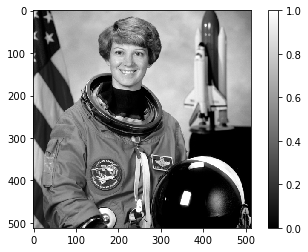

In [16]:
plt.imshow(f, cmap='gray')
plt.colorbar()

Let's now transform this image using a certain displacement field. We will use the [scikit-image swirl operation](http://scikit-image.org/docs/dev/auto_examples/transform/plot_swirl.html#sphx-glr-auto-examples-transform-plot-swirl-py) for this 

In [28]:
from skimage.transform import swirl
g = swirl(f, rotation=0, strength=1, radius=500)

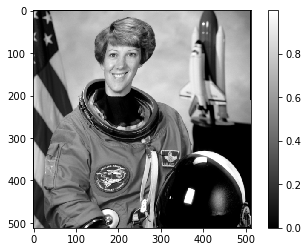

In [29]:
plt.imshow(g, cmap='gray')
plt.colorbar()

## Defining the Q1 finite element basis 

Let's now define our finite element basis. As in the paper by Hild & Roux, we will use [Q1 finite elements](http://people.inf.ethz.ch/arbenz/FEM16/pdfs/0-19-852868-X.pdf). One element is defined by the value it takes on the four edges of the quadrilateral element.

The element basis functions for $[0, h] \times [0, h] $are:

$$
\left\{ 
\begin{array}{lr} 
(1 − x/h)(1 − y/h)\\
x/h(1 − y/h)\\
xy/h^2\\
(1 − x/h)y/h
\end{array}
\right.
$$

Let's look at what this looks like in 2D and 3D.

In [37]:
def q1_element_func(a, b, c, d, h=1):
    """Returns a function valid on the hxh square."""
    b1 = lambda x,y: a * (1 - x/h)*(1 - y/h)
    b2 = lambda x,y: b * x/h*(1 - y/h)
    b3 = lambda x,y: c * x * y / h**2
    b4 = lambda x,y: d * (1 - x/h) * y/h
    return lambda x,y: b1(x,y) + b2(x,y) + b3(x,y) + b4(x,y)

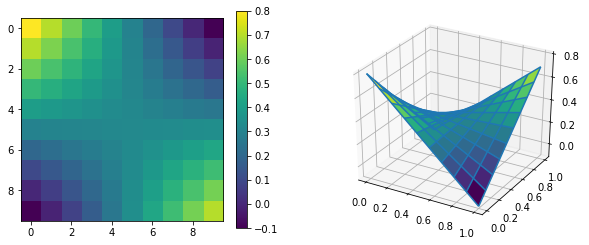

In [70]:
from mpl_toolkits.mplot3d import Axes3D

@interact
def plot_finite_element(a=(-1, 1, 0.1), 
                        b=(-1, 1, 0.1), 
                        c=(-1, 1, 0.1), 
                        d=(-1, 1, 0.1)):
    """Demonstrates the Q1 finite element in an interactive way."""
    num = 10
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    
    basis_func = q1_element_func(a, b, c, d)
    x = np.linspace(0, 1, num=num)[:, np.newaxis]
    y = np.linspace(0, 1, num=num)[np.newaxis, :]
    mapping = basis_func(x, y)
    mappable = ax1.imshow(mapping)
    plt.colorbar(mappable)
    X, Y = np.meshgrid(x, y)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, mapping, cmap='viridis')
    ax2.plot_wireframe(X, Y, mapping)
    

Let's do a plot for each the basis functions.

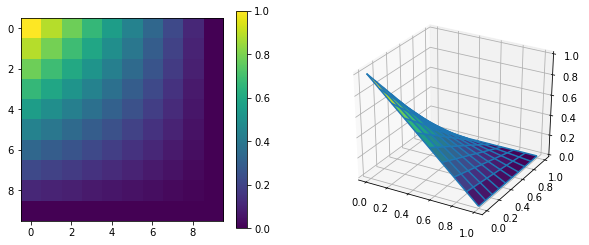

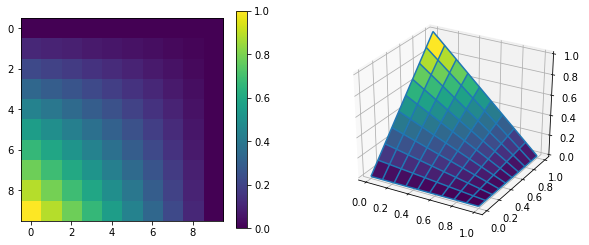

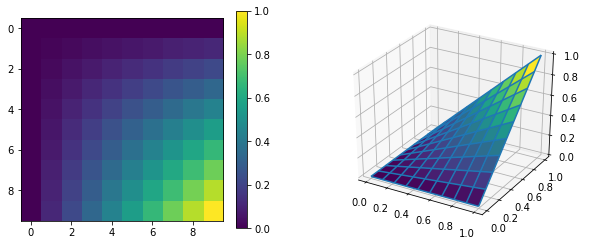

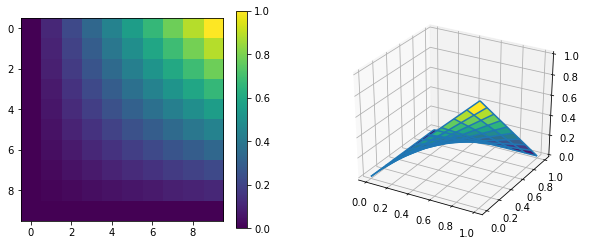

In [72]:
plot_finite_element(1, 0, 0, 0)
plot_finite_element(0, 1, 0, 0)
plot_finite_element(0, 0, 1, 0)
plot_finite_element(0, 0, 0, 1)

## Building a mesh 

Let's build a mesh. We have a rectangular grid and need to define a numbering of points as well as a correspondance to elements.

In [73]:
x = np.arange(3)
y = np.arange(2)
X, Y = np.meshgrid(x, y)

In [78]:
X.ravel()

array([0, 1, 2, 0, 1, 2])

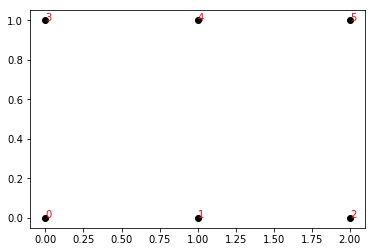

In [81]:
plt.plot(X, Y, 'ko')
for i in range(X.ravel().size):
    plt.text(X.ravel()[i], Y.ravel()[i], str(i), fontdict={'color': 'red'})

Now that we have come this far, we have to compute the terms of the M matrix. Since the displacement field we are looking for is composed of components along the x direction and along the y direction at each node of the image, this means that the M matrix will be sparse. For each basis function, of which there are N_pixels * N_pixels, we need to compute the value in the.

In [ ]:
for basis_function in funcs:
    for other_basis_function in funcs:
        if common_edge(basis_function, other_basis_function):
            compute_coef(basis_function, other_basis_function)